# **CS 1810 Homework 2**
---
To account for potential version issues, try the following in your terminal:

1. Create a new environment with `python3 -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever you use to run your code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

Note that this is not necessary but can help prevent any issues due to package versions.

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn
from scipy.stats import mode
from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

In [42]:
### Data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

### Data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Automatically Rejected": 0,
    "Require Guarantor": 1,
    "Automatically Accepted": 2
}
data['Type'] = data['Type'].map(mapper)
X_applicants = data[['Debt to Income Ratio', 'Credit Score']].values

# transformation as described in problem statement
def transform(X):
  X = np.stack((X[:,0]*20/0.7-7.5, X[:,1]/140 - (500/140+0.5)), axis=1)
  return X
# Transformation
X_applicants = transform(X_applicants)
y_applicants = data['Type'].values

# Problem 1

## Problem 1 Subpart 1

In [14]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    return np.stack([np.ones(len(t)), t, t**2], axis=1)
    

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    return np.stack([np.ones(len(t)), t, t**2, t**3, t**4, t**5], axis=1)
    


In [17]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    def sigmoid(self, z):
        """Sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1)
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        
         # Number of samples
        n = x.shape[0] 

        for i in range(self.runs):
            # Compute predictions (sigmoid)
            y_pred = self.sigmoid(x @ self.W)

            # Compute gradient
            gradient = (x.T @ (y_pred - y)) / n

            # Update weights 
            self.W -= self.eta * gradient
        pass

    def predict(self, x):
        """
        Predict classification probability of transformed input x

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        return self.sigmoid(x @ self.W)

In [18]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

1.3706113594753706
Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Fail


/var/folders/2j/265z53h12ggd9bsj771vs11w0000gn/T/ipykernel_39099/729883142.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [28]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig('img_output/' + title + '.png')
    plt.show()

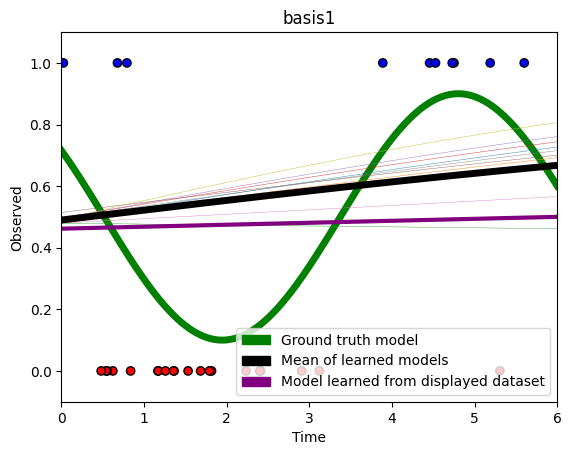

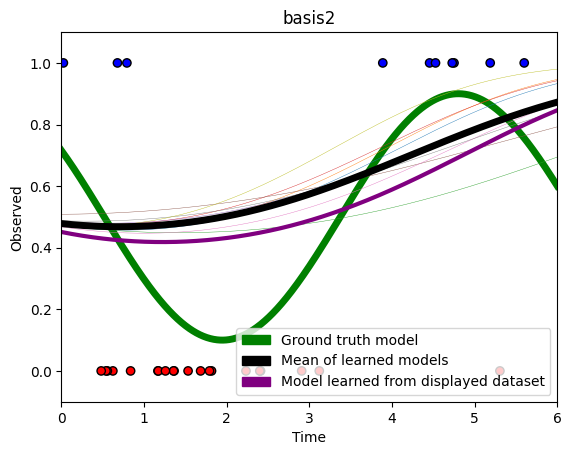

Classification probabilities for t = 0.1: 0.49897088321061844, t = 3.2: 9.358501642951744e-06
Model variances for t = 0.1: 0.00027756844688725014, t = 3.2: 0.15752515480894905


/var/folders/2j/265z53h12ggd9bsj771vs11w0000gn/T/ipykernel_39099/729883142.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


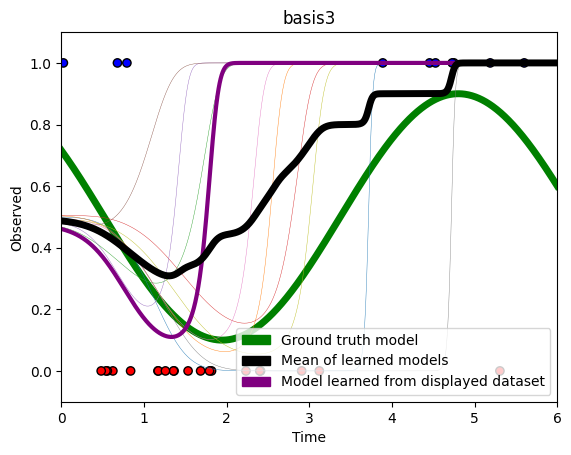

In [29]:
def plot_results(basis, title):
    eta = 0.001
    runs = 1000

    # For Problem 1.4
    test_points_1 = []
    test_points_2 = []
    t1 = basis(np.array([0.1]))
    t2 = basis(np.array([3.2]))

    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

        if basis == basis3:
            # extract values from (1 x 1) array
            pred_1 = model.predict(t1)[0, 0]
            pred_2 = model.predict(t2)[0, 0]
            if i == 0:
                print(f"Classification probabilities for t = 0.1: {pred_1}, t = 3.2: {pred_2}")
            test_points_1.append(pred_1)
            test_points_2.append(pred_2)

    if basis == basis3:
        print(f"Model variances for t = 0.1: {np.var(test_points_1)}, t = 3.2: {np.var(test_points_2)}")
    visualize_prediction_lines(x, y, all_models, basis, title)

plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

Other: 203.0
Original: 155.0


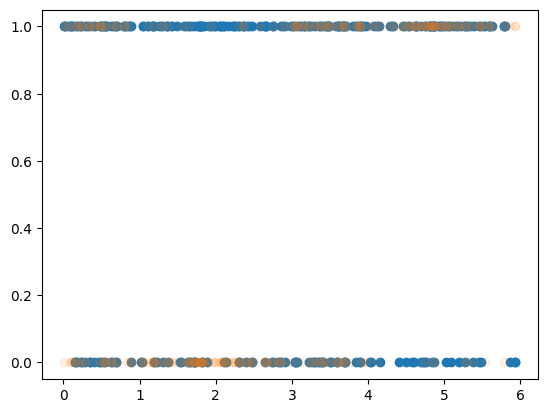

In [224]:
## EXPLORATION OF OTHER DATASET


(_, x, y) = np.genfromtxt("data/planet-obs-alternate.csv", delimiter = ',', skip_header=1).T


plt.scatter(x,y)

t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T

# print(np.size(t_obs))



plt.scatter(t_obs, y_obs, alpha=0.1)
plt.xticks(None)

print(f"Other: {sum(y)}")
print(f"Original: {sum(y_obs)}")

# Problem 3

In [416]:
class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance

    def fit(self, X, y):
        """
        Compute the means and (shared) covariance matrix of the data. Compute the prior over y.

        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
        :return: None
        """
        
        self.mu = {}
        self.cov = {}

        y = y.astype(int)
        
        self.classes = np.unique(y)
        self.priors = {c: np.mean(y == c) for c in self.classes}  

        if self.is_shared_covariance:
            self.cov = np.cov(X, rowvar=False)  
            for c in self.classes:
                self.mu[c] = np.mean(X[y == c], axis=0)
        else:
            for c in self.classes:
                self.mu[c] = np.mean(X[y == c], axis=0)
                self.cov[c] = np.cov(X[y == c], rowvar=False)

        pass

    def predict(self, X_pred):
        """
        Predict classes of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        
        preds = [] 

        for x in X_pred:
            posteriors = []
            
            for c in self.classes:
                mean = self.mu[c]
                cov = self.cov if self.is_shared_covariance else self.cov[c]
                likelihood = mvn.pdf(x, mean=mean, cov=cov)
                posterior = likelihood * self.priors[c]
                posteriors.append(posterior)

            preds.append(self.classes[np.argmax(posteriors)])

        return np.array(preds)


    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Automatically Rejected=index 0, Require Guarantor=index 1, Automatically Accepted=index 2).
                 Shape should be (n x 3)
        """
        probs = []
        for x in X_pred:
            posteriors = []
            
            for c in self.classes:
                mean = self.mu[c]
                cov = self.cov if self.is_shared_covariance else self.cov[c]
                likelihood = mvn.pdf(x, mean=mean, cov=cov)
                posterior = likelihood * self.priors[c]
                posteriors.append(posterior)

            probs.append(np.array(posteriors)/ sum(posteriors))

        return np.array(probs)


    def negative_log_likelihood(self, X, y):
        """
        Given the data X, use previously calculated class means and covariance matrix to
        calculate the negative log likelihood of the data
        """

        # From q2: is the sum of ln pi_yi p(x_i|y_i)

        nll = 0
        for i, x in enumerate(X):
            c = y[i]
            mean = self.mu[c]
            cov = self.cov if self.is_shared_covariance else self.cov[c]
            prob = mvn.pdf(x, mean=mean, cov=cov)
            nll -= np.log(prob * self.priors[c])

        return nll

    pass

In [452]:
class SoftmaxRegression:
    def __init__(self, eta, lam, iter, verbose=True):
        self.eta = eta  
        self.lam = lam  
        self.iter = iter 
        self.verbose = verbose  

    # Softmax function
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    # Forward pass
    def forward(self, X, W, b):
        X_aug = np.c_[np.ones(X.shape[0]), X] 
        Z = np.dot(X_aug, W) + b
        return self.softmax(Z)

    # Loss function with L2 regularization
    def loss(self, Y, Y_hat, W, lamb):
        m = Y.shape[0]
        # Cross-entropy loss
        loss = -np.sum(Y * np.log(Y_hat)) / m
        # L2 regularization (for weights only, not bias)
        reg = (lamb / (2 * m)) * np.sum(W**2)
        return loss + reg

    # Backpropagation to compute gradients
    def backprop(self, X, Y, Y_hat, W, lambda_reg):
        n = X.shape[0]
        X_aug = np.c_[np.ones(X.shape[0]), X] 
        dZ = Y_hat - Y 

        # gradients for weights and bias
        dW = np.dot(X_aug.T, dZ)
        db = np.sum(dZ, axis=0, keepdims=True) 

        # Add L2 regularization term for weights
        dW += (lambda_reg) * W

        return dW, db

    # Fit the model using gradient descent
    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
        :return: None
        """
        # One-hot encode the labels (y)
        Y = np.eye(np.max(y) + 1)[y]  

        # Initialize weights and biases
        num_features = X.shape[1]
        num_classes = len(np.unique(y))
        self.W = np.random.randn(num_features + 1, num_classes) * 0.01 
        self.b = np.zeros((1, num_classes))  

        for i in range(self.iter):
            Y_hat = self.forward(X, self.W, self.b)
            cost = self.loss(Y, Y_hat, self.W, self.lam) 
            dW, db = self.backprop(X, Y, Y_hat, self.W, self.lam) 

            # Update weights and bias
            self.W -= self.eta * dW
            self.b -= self.eta * db

            # Optionally print the cost to monitor progress
            if self.verbose and i % 1000 == 0:
                print(f"Iteration {i}, Cost: {cost}")
        print("Final Weights (W):", self.W)
        print("Final Biases (b):", self.b)

    # Predict the class of each sample
    def predict(self, X_pred):
        """
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        probs = self.forward(X_pred, self.W, self.b)
        return np.argmax(probs, axis=1)

    # Predict the probabilities of each class for the samples
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Automatically Rejected=index 0, Require Guarantor=index 1, Automatically Accepted=index 2).
                 Shape should be (n x 3)
        """
        return self.forward(X_pred, self.W, self.b)  


In [453]:
import heapq
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k

    def distance(self, x1, x2):
        """Compute the given distance metric."""
        return ((x1[0] - x2[0])**2 / 9) + (x1[1] - x2[1])**2

    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y
        
    def predict(self, X_pred_many):
        """
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        preds = []
        for x_p in X_pred_many:
            
            distances = [self.distance(x_p, x) for x in self.X]

            neighbor_i = np.argsort(distances)[:self.K]
            neighbor_val = [self.y[i] for i in neighbor_i]
        
            preds.append(mode(neighbor_val).mode)
            
        
        return np.array(preds)


In [454]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """

    return np.column_stack((np.log(X[:, 0] + 10), X[:, 1]**2))

## Plotting Function for Problem 3, Subpart 1

In [455]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=10):
    # Create a grid of points
    x_min, x_max = min(X[:, 0]-width*0.15), max(X[:, 0]+width*0.15)
    y_min, y_max = min(X[:, 1]-width*0.2), max(X[:, 1]+width*0.2)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T

    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Debt to Income Ratio')
    plt.ylabel('Credit Score')

    ticks = np.transpose(np.array([[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                                   [300, 400, 500, 600, 700, 800, 900, 1000]]))
    transformed_ticks = transform(ticks)


    plt.xticks(transformed_ticks[:,0],
               ticks[:,0])
    plt.yticks(transformed_ticks[:,1],
               ticks[:,1])
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Automatically Rejected')
    blue = mpatches.Patch(color='blue', label='Require Guarantor')
    green = mpatches.Patch(color='green', label='Automatically Accepted')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig('img_output/' + title + '.png')
    plt.show()

## Problem 3, Subpart 1

In [456]:
# DATA has been processed above

# X_applicants and y_applicants are values


In [457]:
## Fit the shared Gaussian Generative 

gauss_shared = GaussianGenerativeModel(is_shared_covariance= True)

gauss_shared.__init__

gauss_shared.fit(X_applicants, y_applicants)



In [458]:
## Fit the unshared Gaussian Generative 

gauss = GaussianGenerativeModel(is_shared_covariance= False)

gauss.__init__

gauss.fit(X_applicants, y_applicants)



In [459]:
## Fit the Softmax Regression

model_softm = SoftmaxRegression(eta=0.001, lam=0.001, iter=200000)

model_softm.fit(X_applicants, y_applicants)

Iteration 0, Cost: 1.1151470546762243
Iteration 1000, Cost: 0.29822555029026615
Iteration 2000, Cost: 0.2260073960492404
Iteration 3000, Cost: 0.1904641591683579
Iteration 4000, Cost: 0.16826915330807402
Iteration 5000, Cost: 0.15273644025379712
Iteration 6000, Cost: 0.14109129356409864
Iteration 7000, Cost: 0.13194483072577515
Iteration 8000, Cost: 0.12451498895608692
Iteration 9000, Cost: 0.11832365679953377
Iteration 10000, Cost: 0.11306011749218589
Iteration 11000, Cost: 0.10851264171309156
Iteration 12000, Cost: 0.10453138232035794
Iteration 13000, Cost: 0.10100694853834073
Iteration 14000, Cost: 0.09785739125293008
Iteration 15000, Cost: 0.09501995906485738
Iteration 16000, Cost: 0.0924456886577495
Iteration 17000, Cost: 0.09009574633308154
Iteration 18000, Cost: 0.08793888846654707
Iteration 19000, Cost: 0.08594965805298796
Iteration 20000, Cost: 0.08410707801534999
Iteration 21000, Cost: 0.08239368741447375
Iteration 22000, Cost: 0.08079481915439889
Iteration 23000, Cost: 0.079

In [ ]:
## Fit the mapped softmax classifier

X_app_map = phi(X_applicants)

mapped_softm = SoftmaxRegression(eta=0.001, lam=0.001, iter=200000)

mapped_softm.fit(X_app_map, y_applicants)


Iteration 0, Cost: 1.100026085350562
Iteration 1000, Cost: 0.6232606664595555
Iteration 2000, Cost: 0.5380769062665107
Iteration 3000, Cost: 0.4990788269505743
Iteration 4000, Cost: 0.47644056413712094
Iteration 5000, Cost: 0.46141235687066745
Iteration 6000, Cost: 0.4505747494139762
Iteration 7000, Cost: 0.44231483478207184
Iteration 8000, Cost: 0.435767301799359
Iteration 9000, Cost: 0.4304229217855907
Iteration 10000, Cost: 0.42596056735411836
Iteration 11000, Cost: 0.42216664097225853
Iteration 12000, Cost: 0.4188929436454017
Iteration 13000, Cost: 0.4160330778028694
Iteration 14000, Cost: 0.41350847277996045
Iteration 15000, Cost: 0.41125971869251887
Iteration 16000, Cost: 0.4092409806453539
Iteration 17000, Cost: 0.4074162783974624
Iteration 18000, Cost: 0.40575693775051397
Iteration 19000, Cost: 0.4042398014735959
Iteration 20000, Cost: 0.4028459462761614
Iteration 21000, Cost: 0.401559745167434
Iteration 22000, Cost: 0.4003681706317372
Iteration 23000, Cost: 0.39926026893268585

In [461]:
# Fit the KNN with 1 nearest neighbor

knn_1 = KNNClassifier(k=1)

knn_1.fit(X_applicants, y_applicants)


In [462]:
# Fit the KNN with 5 NNs

knn_5 =KNNClassifier(k=5)

knn_5.fit(X_applicants, y_applicants)

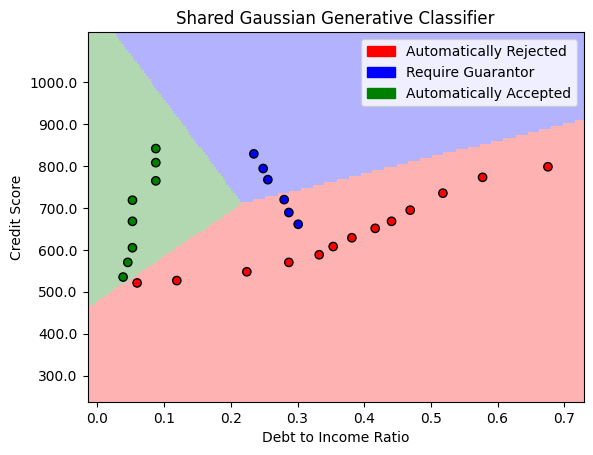

In [463]:
# PLOT MODEL 1

## Gaussian Shared

visualize_boundary(gauss_shared, X_applicants, y_applicants, 'Shared Gaussian Generative Classifier')

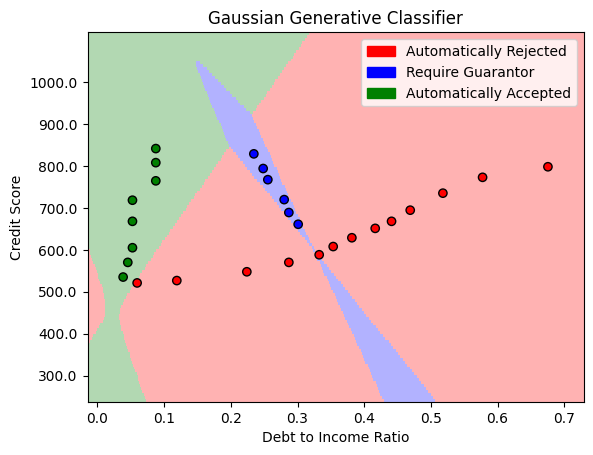

In [464]:
# PLOT MODEL 2:

## Unshared Guassian

visualize_boundary(gauss, X_applicants, y_applicants, 'Gaussian Generative Classifier')

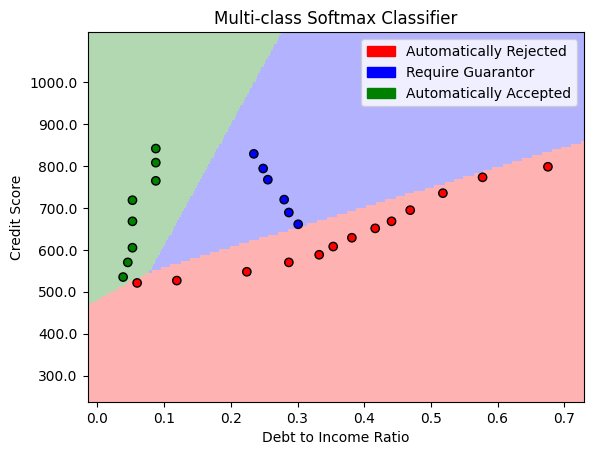

In [465]:
# PLOT MODEL 3

## Softmax

visualize_boundary(model_softm, X_applicants, y_applicants, 'Multi-class Softmax Classifier')

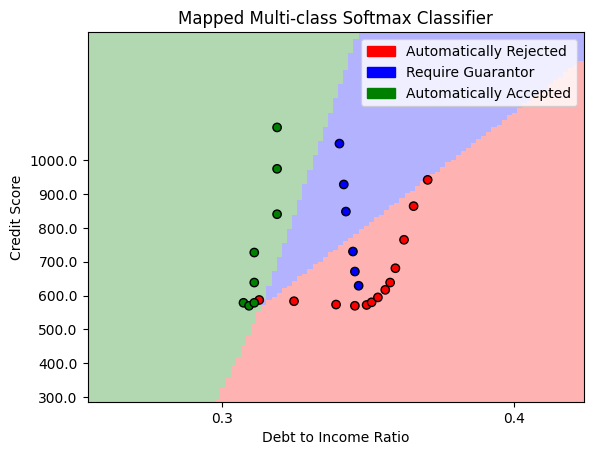

In [470]:
# PLOT MODEL 4

## Mapped Softmax

visualize_boundary(mapped_softm, X_app_map, y_applicants, 'Mapped Multi-class Softmax Classifier')

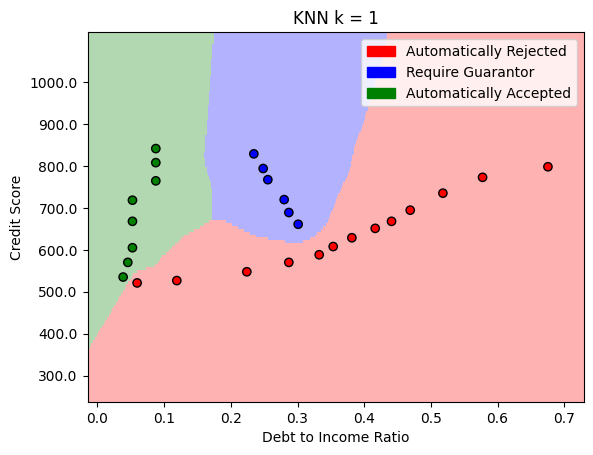

In [467]:
# PLOT MODEL 4

## KNN 1

visualize_boundary(knn_1, X_applicants, y_applicants, 'KNN k = 1')

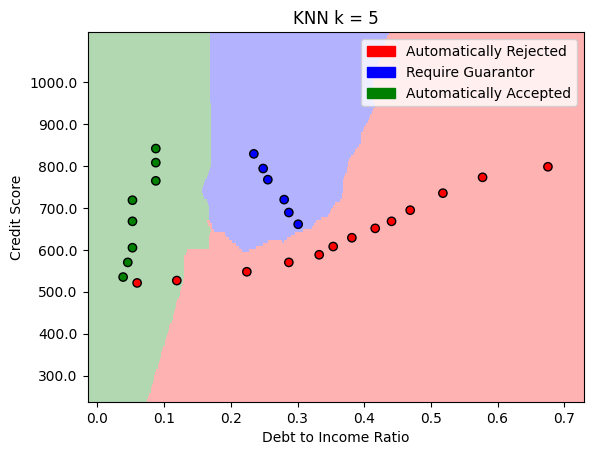

In [468]:
# PLOT MODELS:::

## Gaussian Shared

visualize_boundary(knn_5, X_applicants, y_applicants, 'KNN k = 5')

## Problem 3, Subpart 2

In [471]:
# Predicting for new applicant
point = transform(np.array([(0.32, 350)]))
print(point)

models = [(gauss_shared, "Shared Gaussian"), 
          (gauss, "Gaussian"), 
          (model_softm, "Multi-class Softmax Classifier"),
          (mapped_softm, "Basis Multi-class Softmax Classifier"), (knn_1, "KNN k=1"), (knn_5, "KNN k=5")]
for model in models:
  if model[0] != mapped_softm:
    p = model[0].predict(point)
  else: 
    point_map = phi(point)
    p = model[0].predict(point_map)
  print(f"{model[1]} at (0.32, 350) predicts class: {p[0]}")


print(f"The predicted probabilities for multi-class softmax classifier is {model_softm.predict_proba(point)}")
print(f"The predicted probabilities for multi-class softmax classifier is {mapped_softm.predict_proba(point_map)}")

  

[[ 1.64285714 -1.57142857]]
Shared Gaussian at (0.32, 350) predicts class: 0
Gaussian at (0.32, 350) predicts class: 0
Multi-class Softmax Classifier at (0.32, 350) predicts class: 0
Basis Multi-class Softmax Classifier at (0.32, 350) predicts class: 1
KNN k=1 at (0.32, 350) predicts class: 0
KNN k=5 at (0.32, 350) predicts class: 0
The predicted probabilities for multi-class softmax classifier is [[1.00000000e+00 3.37978041e-23 2.33032653e-35]]
The predicted probabilities for multi-class softmax classifier is [[2.19047413e-01 7.80928775e-01 2.38124931e-05]]
